# Petfinder.my Adoption Prediction
How cute is that doggy in the shelter?

## Competition Description:

Millions of stray animals suffer on the streets or are euthanized in shelters every day around the world. If homes can be found for them, many precious lives can be saved — and more happy families created.

PetFinder.my has been Malaysia’s leading animal welfare platform since 2008, with a database of more than 150,000 animals. PetFinder collaborates closely with animal lovers, media, corporations, and global organizations to improve animal welfare.

Animal adoption rates are strongly correlated to the metadata associated with their online profiles, such as descriptive text and photo characteristics. As one example, PetFinder is currently experimenting with a simple AI tool called the Cuteness Meter, which ranks how cute a pet is based on qualities present in their photos.

In this competition you will be developing algorithms to predict the adoptability of pets - specifically, how quickly is a pet adopted? If successful, they will be adapted into AI tools that will guide shelters and rescuers around the world on improving their pet profiles' appeal, reducing animal suffering and euthanization.

Top participants may be invited to collaborate on implementing their solutions into AI tools for assessing and improving pet adoption performance, which will benefit global animal welfare.

## Objective:
you will predict the speed at which a pet is adopted, based on the pet’s listing on PetFinder. Sometimes a profile represents a group of pets. In this case, the speed of adoption is determined by the speed at which all of the pets are adopted. The data included text, tabular, and image data. See below for details. 

#### AdoptionSpeed

Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way: 
<br>0 - Pet was adopted on the same day as it was listed. 
<br>1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 
<br>2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 
<br>3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
<br>4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).



__File descriptions:__
<br>train.csv - Tabular/text data for the training set
<br>test.csv - Tabular/text data for the test set
<br>sample_submission.csv - A sample submission file in the correct format
<br>breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
<br>color_labels.csv - Contains ColorName for each ColorID
<br>state_labels.csv - Contains StateName for each StateID


Data Fields

- PetID - Unique hash ID of pet profile
- AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
- Type - Type of animal (1 = Dog, 2 = Cat)
- Name - Name of pet (Empty if not named)
- Age - Age of pet when listed, in months
- Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
- Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
- Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
- Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
- Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
- Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
- MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
- FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
- Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
- Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
- Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
- Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
- Quantity - Number of pets represented in profile
- Fee - Adoption fee (0 = Free)
- State - State location in Malaysia (Refer to StateLabels dictionary)
- RescuerID - Unique hash ID of rescuer
- VideoAmt - Total uploaded videos for this pet
- PhotoAmt - Total uploaded photos for this pet
- Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

### Evaluation:

scored based on the quadratic weighted kappa, which measures the agreement between two ratings. This metric typically varies from 0 (random agreement between raters) to 1 (complete agreement between raters). In the event that there is less agreement between the raters than expected by chance, the metric may go below 0. The quadratic weighted kappa is calculated between the scores which are expected/known and the predicted scores.

Results have 5 possible ratings, 0,1,2,3,4.  The quadratic weighted kappa is calculated as follows. First, an N x N histogram matrix O is constructed, such that Oi,j corresponds to the number of adoption records that have a rating of i (actual) and received a predicted rating j. An N-by-N matrix of weights, w, is calculated based on the difference between actual and predicted rating scores:

$$\begin{equation*}
w_{ij} = \frac{(i-j)^2}{(N-1)^2}
\end{equation*} $$


An N-by-N histogram matrix of expected ratings, E, is calculated, assuming that there is no correlation between rating scores.  This is calculated as the outer product between the actual rating's histogram vector of ratings and the predicted rating's histogram vector of ratings, normalized such that E and O have the same sum.

From these three matrices, the quadratic weighted kappa is calculated as: 

$$\begin{equation*}
\kappa = 1 - \frac{\sum_(w_{ij} O_{ij})}{\sum_(w_{ij} E_{ij})}
\end{equation*} $$



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os, json

In [2]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

## Features to add from train dataset
- number of colors
- pure bred or mixed breed
- Description length

In [3]:
color_cols = ['Color1', 'Color2', 'Color3']

In [4]:
def set_breed(row):
    """ this function sets the Mixed Breed Indicator for the pet
        a dog is set as Mixed Breed if either Breed1 or Breed2 = 370
        or both Breed1 and Breed2 is set to some value greater than 0.
        A cat is set as Mixed Breed if either Breed1 or Breed2 = 266
        or both Breed1 and Breed2 is set to some value greater than 0.
    """
    if (row['Type'] == 'Dog'): 
        if (((row['Breed1'] == 370) | (row['Breed2'] == 370)) |
            ((row['Breed1'] > 0) & (row['Breed2'] > 0))):
            return 1
        else:
            return 0
    else: # if 'Cat'
        if (((row['Breed1'] == 266) | (row['Breed2'] == 266)) |
            ((row['Breed1'] > 0) & (row['Breed2'] > 0))):
            return 1 #mixed
        else:
            return 0 #Pure

In [5]:
def get_desc_len(row):
    """ return length of Pet's profile Description"""
    return len(row['Description'])

In [6]:
def get_name_len(row):
    """ return length of Pet's Name"""
    return len(row['Name'])

In [7]:
def get_color_count(row):
    """ return the number of colors of the pet"""
    color_count = 0
    
    for color in color_cols:
        if row[color] > 0:
            color_count +=1
            
    return color_count

In [8]:
def get_age_cat(row):
    """ return the age category for dogs and cats """
    if row['Type'] == 'Dog':
        if (row['Age'] >= 0) & (row['Age'] < 24):
            return 'dog_0_23'
        elif (row['Age'] >= 24) & (row['Age'] < 72):
            return 'dog_24_71'
        elif (row['Age'] >= 72) & (row['Age'] < 120):
            return 'dog_72_119'
        elif row['Age'] >= 120:
            return 'dog_120_above'
    else:
        if (row['Age'] >= 0) & (row['Age'] < 2):
            return 'cat_0_1'
        elif (row['Age'] >= 2) & (row['Age'] < 6):
            return 'cat_2_5'
        elif (row['Age'] >= 6) & (row['Age'] < 12):
            return 'cat_6_11'
        elif row['Age'] >= 12:
            return 'cat_12_above'        

In [9]:
def process_sentiment(filetype):
    """ This function processes the description sentiment file and creates a sentiment score dataframe.
        the filetype (train or test) will be a required parameter"""
    
    path_to_json = '../data/{}_sentiment/'.format(filetype)
    json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
    json_dict = {'pet_id':[],'magnitude':[], 'score':[]}

    for index, js in enumerate(json_files):
     
        with open(os.path.join(path_to_json, js)) as json_file:
            json_text = json.load(json_file)
            json_dict['pet_id'].append(js.split('.')[0])
            json_dict['magnitude'].append(json_text['documentSentiment']['magnitude'])
            json_dict['score'].append(json_text['documentSentiment']['score'])
            
    sentiDF = pd.DataFrame(json_dict)
    return sentiDF

In [10]:
def add_features(df, filetype):
    """ This function adds new features to our dataFrame as part of pre-processing
        of train and test data.  The parameter filetype will either be (train or test)"""
    
    dfAll = df.copy()

    #Handle Missing Values
    dfAll['Name'] = dfAll.Name.fillna('').values
    dfAll['Description'] = dfAll.Name.fillna('').values
    
    
    #Add Features
    dfAll['Name_Ind'] = dfAll['Name'].apply(lambda x: 1 if len(x) > 0 else 0)
    dfAll['Name_Len'] = dfAll.apply(lambda x: get_name_len(x), 1)
    dfAll['Breed_Ind'] = dfAll.apply(lambda x: set_breed(x), 1)
    dfAll['Desc_Len'] = dfAll.apply(lambda x: get_desc_len(x), 1)
    dfAll['Color_count'] = dfAll.apply(lambda x: get_color_count(x), 1)
    dfAll['age_cat'] = dfAll.apply(lambda x:get_age_cat(x), 1)  

    #Get descriptions for the different numeric categorical features
    colors_dict = {k: v for k, v in zip(color['ColorID'], color['ColorName'])}
    dfAll['Color1_name'] = dfAll['Color1'].apply(lambda x: '_'.join(colors_dict[x].split()) if x in colors_dict else 'Unknown')
    dfAll['Color2_name'] = dfAll['Color2'].apply(lambda x: '_'.join(colors_dict[x]) if x in colors_dict else '-')
    dfAll['Color3_name'] = dfAll['Color3'].apply(lambda x: '_'.join(colors_dict[x]) if x in colors_dict else '-')
    
    breeds_dict = {k: v for k, v in zip(breed['BreedID'], breed['BreedName'])}
    dfAll['Breed1_name'] = dfAll['Breed1'].apply(lambda x: '_'.join(breeds_dict[x].split()) if x in breeds_dict else 'Unknown')
    dfAll['Breed2_name'] = dfAll['Breed2'].apply(lambda x: '_'.join(breeds_dict[x]) if x in breeds_dict else '-')
    
    
    #After all the new columns have been added to the dataframe.  Join dfAll with desc_df to populate
    #the dataframe with the description sentiment score
    desc_df = process_sentiment(filetype)
    desc_df.rename(index=str, columns={'pet_id': 'PetID'}, inplace=True)
    dfAll = dfAll.merge(desc_df, on=['PetID'], how='left')
    dfAll.fillna(0, inplace=True)
    
    dfAll['sentiment'] = dfAll.apply(lambda x: x['magnitude'] * x['score'], 1)
    
    return dfAll

In [11]:
#load files

breed = pd.read_csv('../data/breed_labels.csv')
color = pd.read_csv('../data/color_labels.csv')
state = pd.read_csv('../data/state_labels.csv')

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test/test.csv')

In [12]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [13]:
dfAll = add_features(train, 'train')

In [14]:
dfAll.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Name_Ind', 'Name_Len', 'Breed_Ind', 'Desc_Len', 'Color_count',
       'age_cat', 'Color1_name', 'Color2_name', 'Color3_name', 'Breed1_name',
       'Breed2_name', 'magnitude', 'score', 'sentiment'],
      dtype='object')

In [15]:
dfAll.isnull().sum()

Type             0
Name             0
Age              0
Breed1           0
Breed2           0
Gender           0
Color1           0
Color2           0
Color3           0
MaturitySize     0
FurLength        0
Vaccinated       0
Dewormed         0
Sterilized       0
Health           0
Quantity         0
Fee              0
State            0
RescuerID        0
VideoAmt         0
Description      0
PetID            0
PhotoAmt         0
AdoptionSpeed    0
Name_Ind         0
Name_Len         0
Breed_Ind        0
Desc_Len         0
Color_count      0
age_cat          0
Color1_name      0
Color2_name      0
Color3_name      0
Breed1_name      0
Breed2_name      0
magnitude        0
score            0
sentiment        0
dtype: int64

### Save preprocessed data as pickle file

In [16]:
dfAll.to_pickle('../data/out/PetFinder2_preprocessed.pkl')

### Pre-processing

In [17]:
dfAll = pd.read_pickle('../data/out/PetFinder2_preprocessed.pkl')

In [18]:
dfAll.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14993 entries, 0 to 14992
Data columns (total 38 columns):
Type             14993 non-null int64
Name             14993 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14993 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

In [19]:
corr_num_cols = ['Type','Gender','sentiment', 'score', 'Color_count', 'Desc_Len', 'Name_Len', 
                 'PhotoAmt', 'Quantity', 'Age', 'MaturitySize', 'FurLength',
                 'Sterilized','Dewormed', 'Vaccinated','Health','Fee','State', 'Name_Ind',
                 'Breed_Ind','Color1', 'Color2', 'Color3','Breed1', 'Breed2',]
corr_cat_cols = ['age_cat']

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [22]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(corr_num_cols)),
    ('std_scaler', StandardScaler())
])

In [23]:
Xnum = num_pipeline.fit_transform(dfAll)

In [24]:
Xnum.shape

(14993, 25)

In [25]:
petFinder_cat = dfAll[corr_cat_cols]

In [26]:
PF_cat_encoded, PF_categories = petFinder_cat['age_cat'].factorize()

In [27]:
sc = StandardScaler()

In [28]:
sc.fit(PF_cat_encoded.reshape(-1,1))

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [29]:
cat_scaled = sc.transform(PF_cat_encoded.reshape(-1,1))

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [30]:
cat_scaled.shape

(14993, 1)

In [31]:
dfnew = pd.DataFrame(np.c_[Xnum, cat_scaled], columns=corr_num_cols + corr_cat_cols)
dfnew.head()

,Type,Gender,sentiment,score,Color_count,Desc_Len,Name_Len,PhotoAmt,Quantity,Age,MaturitySize,FurLength,Sterilized,Dewormed,Vaccinated,Health,Fee,State,Name_Ind,Breed_Ind,Color1,Color2,Color3,Breed1,Breed2,age_cat
0,1.088692,-1.138787,0.170422,0.106150,0.007115,-0.365438,-0.365438,-0.828403,-0.391237,-0.410466,-1.573167,-0.780377,0.151502,0.634200,0.402608,-0.183518,1.004184,-0.617338,0.302508,-0.972174,-0.707196,1.377285,-0.630704,0.561610,-0.601669,-0.916338
1,1.088692,-1.138787,-0.975972,-1.700738,0.007115,0.307908,0.307908,-0.541680,-0.391237,-0.520627,0.251848,0.888933,1.917809,2.071408,1.900450,-0.183518,-0.271132,1.694404,0.302508,-0.972174,-0.707196,-0.445889,-0.630704,-0.004539,-0.601669,0.015412
2,-0.918534,-1.138787,0.197082,-0.255228,0.007115,-0.365438,-0.365438,0.891932,-0.391237,-0.520627,0.251848,0.888933,0.151502,-0.803007,-1.095234,-0.183518,-0.271132,-0.617338,0.302508,-0.972174,-0.134185,1.377285,-0.630704,0.694822,-0.601669,0.015412
3,-0.918534,0.328415,0.290393,2.274416,0.007115,-0.634777,-0.634777,1.178654,-0.391237,-0.355385,0.251848,-0.780377,0.151502,-0.803007,-1.095234,-0.183518,1.641842,1.694404,0.302508,-0.972174,-0.707196,-0.445889,-0.630704,0.694822,-0.601669,-0.916338
4,-0.918534,-1.138787,2.169946,1.190283,-1.293769,-0.365438,-0.365438,-0.254958,-0.391237,-0.520627,0.251848,-0.780377,0.151502,0.634200,0.402608,-0.183518,-0.271132,-0.617338,0.302508,-0.972174,-0.707196,-1.175159,-0.630704,0.694822,-0.601669,0.015412


In [32]:
X  = dfnew.as_matrix()

In [33]:
from sklearn.metrics import make_scorer, cohen_kappa_score

# Metric used for this competition (Quadratic Weigthed Kappa aka Quadratic Cohen Kappa Score)
def metric(y1,y2):
    return cohen_kappa_score(y1,y2, weights='quadratic')

# Make scorer for scikit-learn
scorer = make_scorer(metric)

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    fig = plt.figure(figsize=(10,5))
    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.tight_layout()


## Select and Train a Model

In [36]:
X.shape

(14993, 26)

In [35]:
y = dfAll['AdoptionSpeed'].values
y.shape

(14993,)

In [36]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import SGDClassifier

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [38]:
SEED = 42

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)


In [40]:
print(X.shape, y.shape)

(14993, 26) (14993,)


In [41]:
from sklearn.model_selection import cross_val_predict

### Hyperparameter Tuning 

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RF

In [52]:
X.shape

(14993, 26)

In [53]:
rf_param_list = {
              #'max_features': ['auto','sqrt','log2'],
            'max_depth': [1, 3, 5, 10],
            'max_features': [0.2, 0.5, 0.7],
              'n_estimators': [100, 200, 300],
              'min_samples_leaf': [1, 10, 50],
    
}

In [54]:
rf = RF(n_jobs=-1, criterion='entropy')

In [55]:
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_list, cv=3, 
                       scoring=scorer, verbose=2)

In [56]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=100, total=   0.3s
[CV] max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=100, total=   0.3s
[CV] max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=100, total=   0.3s
[CV] max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=200, total=   0.4s
[CV] max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=200, total=   0.4s
[CV] max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=200, total=   0.5s
[CV] max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=300 
[CV]  max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=300, total=   0.6s
[CV] max_depth=1, max_features=0.2, min_samples_leaf=1, n_estimators=300 
[CV]  max_depth=1, max

[CV]  max_depth=1, max_features=0.5, min_samples_leaf=50, n_estimators=300, total=   0.6s
[CV] max_depth=1, max_features=0.5, min_samples_leaf=50, n_estimators=300 
[CV]  max_depth=1, max_features=0.5, min_samples_leaf=50, n_estimators=300, total=   0.7s
[CV] max_depth=1, max_features=0.5, min_samples_leaf=50, n_estimators=300 
[CV]  max_depth=1, max_features=0.5, min_samples_leaf=50, n_estimators=300, total=   0.7s
[CV] max_depth=1, max_features=0.7, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=1, max_features=0.7, min_samples_leaf=1, n_estimators=100, total=   0.4s
[CV] max_depth=1, max_features=0.7, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=1, max_features=0.7, min_samples_leaf=1, n_estimators=100, total=   0.4s
[CV] max_depth=1, max_features=0.7, min_samples_leaf=1, n_estimators=100 
[CV]  max_depth=1, max_features=0.7, min_samples_leaf=1, n_estimators=100, total=   0.4s
[CV] max_depth=1, max_features=0.7, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=1

[CV]  max_depth=3, max_features=0.2, min_samples_leaf=50, n_estimators=100, total=   0.3s
[CV] max_depth=3, max_features=0.2, min_samples_leaf=50, n_estimators=200 
[CV]  max_depth=3, max_features=0.2, min_samples_leaf=50, n_estimators=200, total=   0.4s
[CV] max_depth=3, max_features=0.2, min_samples_leaf=50, n_estimators=200 
[CV]  max_depth=3, max_features=0.2, min_samples_leaf=50, n_estimators=200, total=   0.5s
[CV] max_depth=3, max_features=0.2, min_samples_leaf=50, n_estimators=200 
[CV]  max_depth=3, max_features=0.2, min_samples_leaf=50, n_estimators=200, total=   0.4s
[CV] max_depth=3, max_features=0.2, min_samples_leaf=50, n_estimators=300 
[CV]  max_depth=3, max_features=0.2, min_samples_leaf=50, n_estimators=300, total=   0.6s
[CV] max_depth=3, max_features=0.2, min_samples_leaf=50, n_estimators=300 
[CV]  max_depth=3, max_features=0.2, min_samples_leaf=50, n_estimators=300, total=   0.6s
[CV] max_depth=3, max_features=0.2, min_samples_leaf=50, n_estimators=300 
[CV]  max_

[CV]  max_depth=3, max_features=0.7, min_samples_leaf=10, n_estimators=300, total=   0.8s
[CV] max_depth=3, max_features=0.7, min_samples_leaf=10, n_estimators=300 
[CV]  max_depth=3, max_features=0.7, min_samples_leaf=10, n_estimators=300, total=   0.8s
[CV] max_depth=3, max_features=0.7, min_samples_leaf=50, n_estimators=100 
[CV]  max_depth=3, max_features=0.7, min_samples_leaf=50, n_estimators=100, total=   0.4s
[CV] max_depth=3, max_features=0.7, min_samples_leaf=50, n_estimators=100 
[CV]  max_depth=3, max_features=0.7, min_samples_leaf=50, n_estimators=100, total=   0.4s
[CV] max_depth=3, max_features=0.7, min_samples_leaf=50, n_estimators=100 
[CV]  max_depth=3, max_features=0.7, min_samples_leaf=50, n_estimators=100, total=   0.4s
[CV] max_depth=3, max_features=0.7, min_samples_leaf=50, n_estimators=200 
[CV]  max_depth=3, max_features=0.7, min_samples_leaf=50, n_estimators=200, total=   0.6s
[CV] max_depth=3, max_features=0.7, min_samples_leaf=50, n_estimators=200 
[CV]  max_

[CV]  max_depth=5, max_features=0.5, min_samples_leaf=10, n_estimators=200, total=   0.7s
[CV] max_depth=5, max_features=0.5, min_samples_leaf=10, n_estimators=200 
[CV]  max_depth=5, max_features=0.5, min_samples_leaf=10, n_estimators=200, total=   0.7s
[CV] max_depth=5, max_features=0.5, min_samples_leaf=10, n_estimators=200 
[CV]  max_depth=5, max_features=0.5, min_samples_leaf=10, n_estimators=200, total=   0.7s
[CV] max_depth=5, max_features=0.5, min_samples_leaf=10, n_estimators=300 
[CV]  max_depth=5, max_features=0.5, min_samples_leaf=10, n_estimators=300, total=   0.9s
[CV] max_depth=5, max_features=0.5, min_samples_leaf=10, n_estimators=300 
[CV]  max_depth=5, max_features=0.5, min_samples_leaf=10, n_estimators=300, total=   0.8s
[CV] max_depth=5, max_features=0.5, min_samples_leaf=10, n_estimators=300 
[CV]  max_depth=5, max_features=0.5, min_samples_leaf=10, n_estimators=300, total=   0.9s
[CV] max_depth=5, max_features=0.5, min_samples_leaf=50, n_estimators=100 
[CV]  max_

[CV]  max_depth=10, max_features=0.2, min_samples_leaf=1, n_estimators=300, total=   1.3s
[CV] max_depth=10, max_features=0.2, min_samples_leaf=10, n_estimators=100 
[CV]  max_depth=10, max_features=0.2, min_samples_leaf=10, n_estimators=100, total=   0.4s
[CV] max_depth=10, max_features=0.2, min_samples_leaf=10, n_estimators=100 
[CV]  max_depth=10, max_features=0.2, min_samples_leaf=10, n_estimators=100, total=   0.4s
[CV] max_depth=10, max_features=0.2, min_samples_leaf=10, n_estimators=100 
[CV]  max_depth=10, max_features=0.2, min_samples_leaf=10, n_estimators=100, total=   0.4s
[CV] max_depth=10, max_features=0.2, min_samples_leaf=10, n_estimators=200 
[CV]  max_depth=10, max_features=0.2, min_samples_leaf=10, n_estimators=200, total=   0.7s
[CV] max_depth=10, max_features=0.2, min_samples_leaf=10, n_estimators=200 
[CV]  max_depth=10, max_features=0.2, min_samples_leaf=10, n_estimators=200, total=   0.7s
[CV] max_depth=10, max_features=0.2, min_samples_leaf=10, n_estimators=200 

[CV]  max_depth=10, max_features=0.7, min_samples_leaf=1, n_estimators=200, total=   1.3s
[CV] max_depth=10, max_features=0.7, min_samples_leaf=1, n_estimators=200 
[CV]  max_depth=10, max_features=0.7, min_samples_leaf=1, n_estimators=200, total=   1.3s
[CV] max_depth=10, max_features=0.7, min_samples_leaf=1, n_estimators=300 
[CV]  max_depth=10, max_features=0.7, min_samples_leaf=1, n_estimators=300, total=   1.9s
[CV] max_depth=10, max_features=0.7, min_samples_leaf=1, n_estimators=300 
[CV]  max_depth=10, max_features=0.7, min_samples_leaf=1, n_estimators=300, total=   1.8s
[CV] max_depth=10, max_features=0.7, min_samples_leaf=1, n_estimators=300 
[CV]  max_depth=10, max_features=0.7, min_samples_leaf=1, n_estimators=300, total=   1.7s
[CV] max_depth=10, max_features=0.7, min_samples_leaf=10, n_estimators=100 
[CV]  max_depth=10, max_features=0.7, min_samples_leaf=10, n_estimators=100, total=   0.6s
[CV] max_depth=10, max_features=0.7, min_samples_leaf=10, n_estimators=100 
[CV]  m

[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:  4.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 3, 5, 10], 'max_features': [0.2, 0.5, 0.7], 'n_estimators': [100, 200, 300], 'min_samples_leaf': [1, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(metric), verbose=2)

In [57]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=0.5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [58]:
y_rf = rf_grid.predict(X_test)
metric(y_test, y_rf)

0.3611159449768838

In [43]:
rf1 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

#with modified max_features.  
rf2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

#grid search best estimator
rf3 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=0.5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)



In [60]:

rf1.fit(X_train, y_train)
rf2.fit(X_train, y_train)
rf3.fit(X_train, y_train)
y_rf1 = rf1.predict(X_test)
y_rf2 = rf2.predict(X_test)
y_rf3 = rf3.predict(X_test)

In [61]:
print(accuracy_score(y_test, y_rf1),metric(y_test, y_rf1))
print(accuracy_score(y_test, y_rf2),metric(y_test, y_rf2))
print(accuracy_score(y_test, y_rf3),metric(y_test, y_rf3))

0.4157403290351267 0.3715036870372589
0.41373943975100047 0.37328540502300567
0.4084037349933304 0.3520509650578283


In [62]:

y_rf1 = rf1.predict(X_train)
y_rf2 = rf2.predict(X_train)
y_rf3 = rf3.predict(X_train)
print(accuracy_score(y_train, y_rf1),metric(y_train, y_rf1))
print(accuracy_score(y_train, y_rf2),metric(y_train, y_rf2))
print(accuracy_score(y_train, y_rf3),metric(y_train, y_rf3))

0.9990471653168176 0.9991678537448181
0.9990471653168176 0.99916785170491
0.5430204859456884 0.44366641214370284


In [63]:
from sklearn.model_selection import cross_val_score

rf1_scores = cross_val_score(rf1, X_train, y_train,
                         scoring=scorer, cv=10)
rf2_scores = cross_val_score(rf2, X_train, y_train,
                         scoring=scorer, cv=10)
rf3_scores = cross_val_score(rf3, X_train, y_train,
                         scoring=scorer, cv=10)

In [65]:

print(rf1_scores.mean())
print(rf2_scores.mean())
print(rf3_scores.mean())

0.33178939581855155
0.3256014849623573
0.3221864126763578


## Using Ensemble Methods

In [67]:
from sklearn.svm import SVC

svm_clf = SVC()

In [69]:
params_poly = { 'kernel': ['poly'],
                'gamma': [0.1, 0.3],
                'coef0': [0, 1],
                'C': [0.1, 0.3, 0.5],
                 'degree': [3, 5,10]
    
}

grid_svm = GridSearchCV(estimator=svm_clf,
                       param_grid=params_poly,
                       scoring=scorer,
                       cv=5,
                       n_jobs=-1,
                       verbose=1)

grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 17.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kernel': ['poly'], 'gamma': [0.1, 0.3], 'coef0': [0, 1], 'C': [0.1, 0.3, 0.5], 'degree': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(metric), verbose=1)

In [ ]:
#best estimator  #best score 0.26175
SVC(C=0.1, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [72]:
grid_svm.best_score_

0.26175682247452037

In [60]:
svm_poly = SVC(C=0.1, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svm_poly.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [95]:
y_svm = svm_poly.predict(X_test)
print(accuracy_score(y_test, y_svm),metric(y_test, y_svm))

0.3723877278790574 0.3020574060008717


In [75]:
svm_scores = cross_val_score(svm_clf2, X_train, y_train,
                         scoring=scorer, cv=10)
print(svm_scores.mean())

0.26667992072962016


In [57]:
# Train Random Forest Classifier


#rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
#            max_depth=None, max_features=0.5, max_leaf_nodes=None,
#            min_impurity_split=1e-07, min_samples_leaf=1,
#            min_samples_split=2, min_weight_fraction_leaf=0.0,
#            n_estimators=300, n_jobs=-1, oob_score=False,
#            random_state=None, verbose=0, warm_start=False)

rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=0.5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=0.5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [80]:
y_pred = rf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(metric(y_test, y_pred))

0.4084037349933304
0.35813351228585166


In [81]:
rf_scores = cross_val_score(rf, X_train, y_train,
                         scoring=scorer, cv=10)

rf_scores.mean()

0.32371985458876357

In [58]:
# Train Extra Trees Classifier

from sklearn.ensemble import ExtraTreesClassifier as ET

et = ET(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=0.5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
et.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy',
           max_depth=10, max_features=0.5, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [83]:
y_et = et.predict(X_test)
print(accuracy_score(y_test, y_et))
print(metric(y_test, y_et))

0.40173410404624277
0.32759345613217516


In [84]:
et_scores = cross_val_score(et, X_train, y_train,
                         scoring=scorer, cv=10)

et_scores.mean()

0.3058760371539117

In [59]:
# Train SVC

from sklearn.svm import SVC

sv = SVC()
sv.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [86]:
y_svc = sv.predict(X_test)
print(accuracy_score(y_test, y_svc))
print(metric(y_test, y_svc))

0.3937305469097377
0.3203739319407899


In [87]:
svc_scores = cross_val_score(sv, X_train, y_train,
                         scoring=scorer, cv=10)
print(svc_scores.mean())

0.28714074076246715


In [88]:
sv_rbf = SVC()
params_rbf = { 'kernel': ['rbf'],
                'gamma': [0.1, 0.3],
                'coef0': [0, 1],
                 'degree': [3, 5,10]
    
}

grid_rbf = GridSearchCV(estimator=sv_rbf,
                       param_grid=params_rbf,
                       scoring=scorer,
                       cv=5,
                       n_jobs=-1,
                       verbose=2)

grid_rbf.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] coef0=0, degree=3, gamma=0.1, kernel=rbf ........................
[CV] coef0=0, degree=3, gamma=0.1, kernel=rbf ........................
[CV] coef0=0, degree=3, gamma=0.1, kernel=rbf ........................
[CV] coef0=0, degree=3, gamma=0.1, kernel=rbf ........................
[CV] ......... coef0=0, degree=3, gamma=0.1, kernel=rbf, total=   9.7s
[CV] coef0=0, degree=3, gamma=0.1, kernel=rbf ........................
[CV] ......... coef0=0, degree=3, gamma=0.1, kernel=rbf, total=   9.7s
[CV] coef0=0, degree=3, gamma=0.3, kernel=rbf ........................
[CV] ......... coef0=0, degree=3, gamma=0.1, kernel=rbf, total=   9.7s
[CV] coef0=0, degree=3, gamma=0.3, kernel=rbf ........................
[CV] ......... coef0=0, degree=3, gamma=0.1, kernel=rbf, total=   9.7s
[CV] coef0=0, degree=3, gamma=0.3, kernel=rbf ........................
[CV] ......... coef0=0, degree=3, gamma=0.1, kernel=rbf, total=   9.7s
[CV] coef0=0, de

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min


[CV] coef0=1, degree=3, gamma=0.3, kernel=rbf ........................
[CV] ......... coef0=1, degree=3, gamma=0.1, kernel=rbf, total=   9.9s
[CV] coef0=1, degree=3, gamma=0.3, kernel=rbf ........................
[CV] ......... coef0=1, degree=3, gamma=0.3, kernel=rbf, total=  11.3s
[CV] coef0=1, degree=3, gamma=0.3, kernel=rbf ........................
[CV] ......... coef0=1, degree=3, gamma=0.3, kernel=rbf, total=  11.8s
[CV] coef0=1, degree=5, gamma=0.1, kernel=rbf ........................
[CV] ......... coef0=1, degree=3, gamma=0.3, kernel=rbf, total=  11.7s
[CV] coef0=1, degree=5, gamma=0.1, kernel=rbf ........................
[CV] ......... coef0=1, degree=3, gamma=0.3, kernel=rbf, total=  11.9s
[CV] coef0=1, degree=5, gamma=0.1, kernel=rbf ........................
[CV] ......... coef0=1, degree=3, gamma=0.3, kernel=rbf, total=  11.2s
[CV] coef0=1, degree=5, gamma=0.1, kernel=rbf ........................
[CV] ......... coef0=1, degree=5, gamma=0.1, kernel=rbf, total=   9.2s
[CV] c

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kernel': ['rbf'], 'gamma': [0.1, 0.3], 'coef0': [0, 1], 'degree': [3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(metric), verbose=2)

In [89]:
grid_rbf.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [90]:
grid_rbf.best_score_

0.26656866743851876

In [91]:
sv_rbf = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svc_scores = cross_val_score(sv_rbf, X_train, y_train,
                         scoring=scorer, cv=10)
print(svc_scores.mean())

0.26829525341940486


In [93]:
sv_rbf.fit(X_train, y_train)
y_sv = sv_rbf.predict(X_test)
metric(y_test, y_sv)

0.3054260187750151

In [97]:
import seaborn as sns

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RF:

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       141
          1       0.36      0.32      0.34       928
          2       0.34      0.45      0.38      1177
          3       0.43      0.16      0.24       984
          4       0.49      0.67      0.57      1268

avg / total       0.40      0.41      0.38      4498



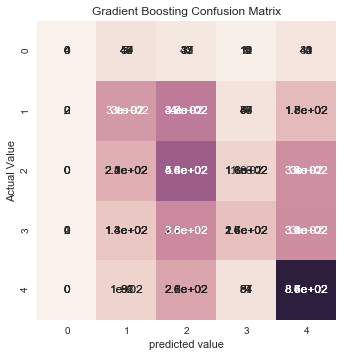


Accuracy:  0.4084037349933304

Kappa Score:  0.35527479035898013
----------


ET:

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       141
          1       0.37      0.24      0.29       928
          2       0.34      0.53      0.41      1177
          3       0.49      0.12      0.19       984
          4       0.48      0.67      0.56      1268

avg / total       0.40      0.40      0.37      4498



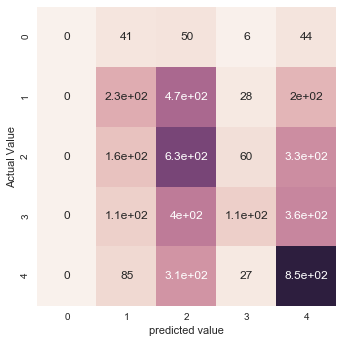


Accuracy:  0.4032903512672299

Kappa Score:  0.334249974013886
----------


SVC poly:

             precision    recall  f1-score   support

          0       0.12      0.03      0.05       141
          1       0.32      0.30      0.31       928
          2       0.32      0.44      0.37      1177
          3       0.32      0.19      0.24       984
          4       0.50      0.53      0.52      1268

avg / total       0.36      0.37      0.36      4498



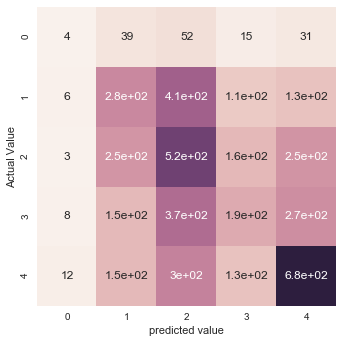


Accuracy:  0.3723877278790574

Kappa Score:  0.3020574060008717
----------




In [61]:
# import scoring method from sklearn
from sklearn.metrics import classification_report

# get validation predictions from each model
#yhat = {'RF': rf.predict(X_test),
#        'ET': et.predict(X_test),
#        'SVC rbf': sv_rbf.predict(X_test),
#        'SVC poly': svm_poly.predict(X_test)}

yhat = {'RF': rf.predict(X_test),
        'ET': et.predict(X_test),
        'SVC poly': svm_poly.predict(X_test)}

# print classification reports for each model
for model in yhat:
    cr = classification_report(y_test, yhat[model])  # ytrue, ypred
    print('{}:\n'.format(model))
    print(cr)
    #plot_classification_report(cr)
    #plt.show()
    sns.heatmap(confusion_matrix(y_test, yhat[model]), square=True, annot=True, cbar=False)
    plt.xlabel('predicted value')
    plt.ylabel('Actual Value')
    plt.show()
    print('\nAccuracy: ',accuracy_score(y_test, yhat[model]))
    print('\nKappa Score: ',metric(y_test, yhat[model]))
    print(10*'-')
    print('\n')

In [62]:
# use the "hard" voting method from predictions made by each model
# bincount returns vector of counts for the interval [0, max_val]
#  e.g. bincount([1,3,1]) -> [0, 2, 0, 1]
ensemble_preds = [np.bincount(list(r)).argmax() for r in np.c_[list(yhat.values())].T]

print(classification_report(y_test, ensemble_preds))


             precision    recall  f1-score   support

          0       0.12      0.01      0.01       141
          1       0.35      0.30      0.32       928
          2       0.34      0.50      0.40      1177
          3       0.46      0.13      0.20       984
          4       0.50      0.65      0.57      1268

avg / total       0.40      0.41      0.38      4498



In [63]:
# Combine classifiers into an Ensemble

from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(estimators=[('rf', rf),('et', et),('sv', sv)], voting='hard')

ensemble_model.fit(X_train, y_train)
y_ensemble = ensemble_model.predict(X_test)

print(classification_report(y_test, y_ensemble))
sns.heatmap(confusion_matrix(y_test, y_ensemble), square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('Actual Value')
plt.title('Voting Classifier Confusion Matrix')
plt.savefig('../images/VC_confusionmat.png')
print('\nAccuracy: ',accuracy_score(y_test, y_ensemble))
print('\nKappa Score: ',metric(y_test, y_ensemble))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       141
          1       0.36      0.29      0.32       928
          2       0.33      0.51      0.40      1177
          3       0.49      0.14      0.21       984
          4       0.50      0.67      0.57      1268

avg / total       0.41      0.41      0.38      4498


Accuracy:  0.4108492663405958

Kappa Score:  0.3592443966630091


/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [80]:
cr = classification_report(y_test, y_ensemble)
plot_classification_report(cr, 'Voting Classifier: Classification Report')
plt.draw()
plt.savefig('../images/VC_classreport.png')

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [107]:
vc_scores = cross_val_score(ensemble_model, X_train, y_train,
                         scoring=scorer, cv=10)
print('\n',vc_scores)

/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth 


 [0.27412861 0.30101668 0.3080534  0.36583907 0.31294784 0.32665915
 0.32402975 0.34009221 0.32518407 0.32309729]


/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [108]:
print('\n',vc_scores.mean())


 0.3201048064543083


### Bagging Classifier

In [49]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report
import seaborn as sns



In [50]:
rf_classifiers = [rf1, rf2, rf3]

for i, rf_class in enumerate(rf_classifiers):
    
    bag_clf = BaggingClassifier(rf_class, random_state=42)  
    bag_clf.fit(X_train, y_train)
    y_bag = bag_clf.predict(X_test)
    print(classification_report(y_test, y_bag))
    sns.heatmap(confusion_matrix(y_test, y_bag), square=True, annot=True, cbar=False)
    plt.xlabel('predicted value')
    plt.ylabel('Actual Value')
    plt.title('Bagging Classification Confusion Matrix rf{}'.format(str(i+1)))
    plt.savefig('../images/BC_confusionmat{}.png'.format(str(i+1)))
   #plt.show()
    print('\nAccuracy: ',accuracy_score(y_test, y_bag))
    print('\nKappa Score: ',metric(y_test, y_bag))

             precision    recall  f1-score   support

          0       0.67      0.03      0.05       141
          1       0.37      0.32      0.34       928
          2       0.35      0.41      0.38      1177
          3       0.42      0.25      0.31       984
          4       0.51      0.68      0.58      1268

avg / total       0.42      0.42      0.40      4498


Accuracy:  0.4212983548243664

Kappa Score:  0.37661789679678914
             precision    recall  f1-score   support

          0       0.50      0.03      0.05       141
          1       0.37      0.34      0.35       928
          2       0.34      0.39      0.37      1177
          3       0.42      0.26      0.32       984
          4       0.51      0.68      0.58      1268

avg / total       0.42      0.42      0.40      4498


Accuracy:  0.4210760337927968

Kappa Score:  0.3828877722658819


/Users/ayeshamendoza/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00       141
          1       0.38      0.32      0.35       928
          2       0.34      0.46      0.39      1177
          3       0.44      0.16      0.23       984
          4       0.49      0.68      0.57      1268

avg / total       0.40      0.41      0.38      4498


Accuracy:  0.4106269453090262

Kappa Score:  0.36460791265712944


In [70]:
bag_clf = BaggingClassifier(rf2, random_state=42)  
bag_clf.fit(X_train, y_train)
y_bag = bag_clf.predict(X_test)

In [81]:
plt.draw()
cr = classification_report(y_test, y_bag)
plot_classification_report(cr, 'Bagging Classifier w/ RF: Classification Report')
plt.draw()
#plt.show()
plt.savefig('../images/BC_classreport.png')

In [113]:
rf_classifiers = [rf1, rf2, rf3]

for i, rf_class in enumerate(rf_classifiers):
    
    bag_clf = BaggingClassifier(rf_class, random_state=42)  
    bc_scores = cross_val_score(bag_clf, X_train, y_train,
                         scoring=scorer, cv=10)
    print('rf{}'.format(str(i+1)))
    print('\n',bc_scores)
    print('\n',bc_scores.mean())

rf1

 [0.28964316 0.30356413 0.31703676 0.37842516 0.31569024 0.35652525
 0.33326984 0.37835363 0.35356298 0.32582937]

 0.33519005098977994
rf2

 [0.29127628 0.3069401  0.31245184 0.36159175 0.33222491 0.35090539
 0.33442636 0.37653168 0.3406257  0.31178901]

 0.3318763009811453
rf3

 [0.28993441 0.30242159 0.32006691 0.35335654 0.31345048 0.33743931
 0.34858855 0.32019177 0.32293116 0.31694524]

 0.32253259584322824


### Bagging Classifier with rf2 classifier: Kaggle Kappa Score: 0.270

In [ ]:
score = metric(y_test, y_ensemble)

In [ ]:
score2 = metric(y_test, v_clf_pred)  #original score 0.264533852895672

In [ ]:
print(score, score2)

### Gradient Boosting 
[hyperparameter tuning](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)



In [51]:
from sklearn.ensemble import GradientBoostingClassifier

In [116]:
gbt_clf = GradientBoostingClassifier(random_state=SEED)

In [117]:
gbt_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

In [118]:
y_pred = gbt_clf.predict(X_test)
score = metric(y_test, y_pred)
print(score)  # original score: 0.29297979606827806

0.38079720863070654


In [120]:
param_list = {
              'n_estimators': [300,400,500],
              'max_depth': [4, 6, 8],
              'min_samples_split': [50, 100, 120],
              'min_samples_leaf': [5, 10, 15],
              'learning_rate': [0.1, 0.3],
              'max_features': [5, 8, 10]
            
    
}

In [121]:
grid_gbt = GridSearchCV(estimator=gbt_clf, param_grid=param_list, cv=3,
                       scoring=scorer,verbose=2,n_jobs=-1)

In [122]:
grid_gbt.fit(X_train, y_train)

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=300 
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=300 
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=300 
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=300, total=   6.7s
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=300, total=   6.8s
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=400 
[C

[CV]  learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=400, total=   9.0s
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=300 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min


[CV]  learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  11.4s
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=300, total=   6.7s
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  11.5s
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  11.3s
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.1

[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=400, total=   8.8s
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=400, total=   8.7s
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=500, total=  10.9s
[CV] learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=4, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=   6.5s
[CV] learning_rate=0

[CV] learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=300, total=   7.7s
[CV] learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=400, total=  10.4s
[CV] learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=400, total=  10.4s
[CV] learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=400, total=  10.4s
[CV] learning_rate=0.1, max_

[CV] learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=120, n_estimators=500, total=  13.5s
[CV] learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=300, total=   8.1s
[CV] learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=300, total=   8.1s
[CV] learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=400, total=  10.7s
[CV] learning_rate=0.1, max

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.5min


[CV]  learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=   7.9s
[CV] learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=   8.1s
[CV] learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=400, total=  10.5s
[CV] learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=400, total=  10.6s
[CV] learning_rate=0.1, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=

[CV] learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=500, total=  14.4s
[CV] learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=500, total=  14.4s
[CV] learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=300, total=   8.9s
[CV] learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=300, total=   9.1s
[CV] learning_rate=0

[CV]  learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=400, total=  12.2s
[CV] learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=500, total=  15.1s
[CV] learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=300, total=   8.6s
[CV] learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=500, total=  15.1s
[CV] learning_rate=0.1, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=400 
[CV]  learning_

[CV] learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=400, total=  12.7s
[CV] learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=400, total=  12.7s
[CV] learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=400, total=  13.1s
[CV] learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=500, total=  16.4s
[CV] learning_rate=0.1, max_

[CV] learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=300, total=   9.3s
[CV] learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=300, total=   9.4s
[CV] learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=400, total=  12.5s
[CV] learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=400, total=  12.4s
[CV] learning_rate=0

[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=300, total=  13.4s
[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=500, total=  16.3s
[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=300, total=  12.9s
[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=300, total=  13.2s
[CV] learning_rate=0.1, max_depth=

[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300 


[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 18.0min


[CV]  learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  21.6s
[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300, total=  11.7s
[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  21.1s
[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  21.4s
[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.1

[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=400, total=  15.2s
[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=400, total=  15.4s
[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=500, total=  20.1s
[CV] learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=  13.0s
[CV] learning_rate=0

[CV] learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=300, total=  13.1s
[CV] learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=400, total=  17.3s
[CV] learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=400, total=  17.6s
[CV] learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=400, total=  17.6s
[CV] learning_rate=0

[CV]  learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=10, min_samples_split=120, n_estimators=500, total=  21.5s
[CV] learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=10, min_samples_split=120, n_estimators=500, total=  21.7s
[CV] learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=300, total=  14.2s
[CV] learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=300, total=  13.9s
[CV] learning_rate=0.1, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=500 
[CV]  learning_rat

[CV] learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=500, total=  25.9s
[CV] learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=300, total=  12.9s
[CV] learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=500, total=  26.0s
[CV] learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=500, total=  26.1s
[CV] learning_rate=0.1, max_dep

[CV] learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=400, total=  17.2s
[CV] learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=400, total=  17.6s
[CV] learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=500, total=  22.1s
[CV] learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=300, total=  12.8s
[CV] learning_rate=0

[CV] learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=  12.7s
[CV] learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=400, total=  16.5s
[CV] learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=400, total=  16.4s
[CV] learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=400, total=  16.6s
[CV] learning_rate=0

[CV] learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=500, total=  26.7s
[CV] learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=300, total=  18.1s
[CV] learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=300, total=  18.7s
[CV] learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=400, total=  25.1s
[CV] learning_rate=0.1, max_

[CV] learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=300, total=  17.1s
[CV] learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=500, total=  34.1s
[CV] learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=500, total=  34.5s
[CV] learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=300, total=  17.9s
[CV] learning_rate=0.1

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 41.4min


[CV]  learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=  17.6s
[CV] learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=  17.7s
[CV] learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=400, total=  23.3s
[CV] learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=400, total=  23.4s
[CV] learning_rate=0.1, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=

[CV] learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=500, total=  29.8s
[CV] learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=500, total=  30.7s
[CV] learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=300, total=  21.1s
[CV] learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=300, total=  21.1s
[CV] learning_rate=0

[CV]  learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=400, total=  27.9s
[CV] learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=500, total=  37.8s
[CV] learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=300, total=  20.9s
[CV] learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=500, total=  38.3s
[CV] learning_rate=0.1, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=400 
[CV]  learning_

[CV] learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=400, total=   9.7s
[CV] learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=400, total=   9.6s
[CV] learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=400, total=   9.5s
[CV] learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=500, total=  11.9s
[CV] learning_rate=0.3, max_

[CV] learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=500, total=  12.0s
[CV] learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=300, total=   7.1s
[CV] learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=400, total=   9.5s
[CV] learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=10, min_samples_split=120, n_estimators=400, total=   9.6s
[CV] learning_rate=0

[CV] learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=300, total=   8.5s
[CV] learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=4, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=500, total=  11.9s
[CV] learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=300, total=   8.7s
[CV] learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=5, min_samples_split=50, n_estimators=300, total=   8.8s
[CV] learning_rate=0.3, max_depth=

[CV] learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  14.8s
[CV] learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300, total=   8.4s
[CV] learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  14.7s
[CV] learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  14.5s
[CV] learning_rate=0.3,

[CV] learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=400, total=  11.3s
[CV] learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=400, total=  11.4s
[CV] learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=100, n_estimators=500, total=  14.4s
[CV] learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=4, max_features=8, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=   8.5s
[CV] learning_rate=0

[CV] learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=300, total=   9.2s
[CV] learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=400, total=  12.9s
[CV] learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=400, total=  12.7s
[CV] learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=5, min_samples_split=120, n_estimators=400, total=  12.8s
[CV] learning_rate=0

[CV]  learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=10, min_samples_split=120, n_estimators=500, total=  15.5s
[CV] learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=10, min_samples_split=120, n_estimators=500, total=  15.5s
[CV] learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=300, total=   9.7s
[CV] learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=300, total=   9.9s
[CV] learning_rate=0.3, max_depth=4, max_features=10, min_samples_leaf=15, min_samples_split=50, n_estimators=500 
[CV]  learning_rat

[CV] learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=500, total=  18.4s
[CV] learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=300, total=  10.8s
[CV] learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=500, total=  18.5s
[CV] learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=5, min_samples_split=50, n_estimators=500, total=  18.5s
[CV] learning_rate=0.3, max_dep

[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 64.9min


[CV]  learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  18.2s
[CV] learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=300, total=  10.4s
[CV] learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  18.1s
[CV] learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  18.3s
[CV] learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.3

[CV] learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=400, total=  14.2s
[CV] learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=400, total=  13.9s
[CV] learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=500, total=  17.1s
[CV] learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=6, max_features=5, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=  10.1s
[CV] learning_rate=0

[CV] learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=300, total=  12.7s
[CV] learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=400, total=  16.9s
[CV] learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=400, total=  17.0s
[CV] learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=400, total=  17.2s
[CV] learning_rate=0.3, max_

[CV] learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=300, total=  14.2s
[CV] learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=300, total=  14.2s
[CV] learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=300, total=  13.9s
[CV] learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=6, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=400, total=  18.4s
[CV] learning_rate=0.3, max_

[CV] learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=50, n_estimators=500, total=  25.3s
[CV] learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=100, n_estimators=300, total=  14.8s
[CV] learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=50, n_estimators=500, total=  25.4s
[CV] learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=5, min_samples_split=100, n_estimators=300, total=  14.6s
[CV] learning_rate=0.3

[CV]  learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=400, total=  20.8s
[CV] learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=400, total=  21.9s
[CV] learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=10, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=500, total=  26.1s
[CV] learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=10, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=10, min_samples_split=120, n_estimators=300, total=  14.3s
[CV] learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=10, min_samples_split=120, n_estimators=300 
[CV]  learni

[CV] learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=  15.5s
[CV] learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=400, total=  21.8s
[CV] learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=400, total=  22.2s
[CV] learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=6, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=400, total=  22.2s
[CV] learnin

[CV] learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=300, total=  14.9s
[CV] learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=300, total=  14.8s
[CV] learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=300, total=  15.1s
[CV] learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=50, n_estimators=400, total=  19.5s
[CV] learning_rate=0.3, max_

[CV] learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=300, total=  13.1s
[CV] learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=50, n_estimators=500, total=  23.5s
[CV] learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=50, n_estimators=500, total=  23.7s
[CV] learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=8, max_features=5, min_samples_leaf=15, min_samples_split=100, n_estimators=300, total=  13.2s
[CV] learning_rate=0.3

[CV] learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=5, min_samples_split=100, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=5, min_samples_split=100, n_estimators=400, total=  21.9s
[CV] learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=5, min_samples_split=100, n_estimators=500, total=  26.7s
[CV] learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=300, total=  16.0s
[CV] learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=5, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=5, min_samples_split=100, n_estimators=500, total=  26.7s
[CV] learning_rate=0.3, max_

[CV] learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=120, n_estimators=400, total=  20.9s
[CV] learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=120, n_estimators=400, total=  20.8s
[CV] learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=120, n_estimators=400, total=  20.8s
[CV] learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=15, min_samples_split=50, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=8, max_features=8, min_samples_leaf=10, min_samples_split=120, n_estimators=500, total=  25.3s
[CV] learning_rate=0.

[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=5, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=5, min_samples_split=50, n_estimators=300, total=  20.7s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=5, min_samples_split=50, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=5, min_samples_split=50, n_estimators=300, total=  20.8s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=5, min_samples_split=50, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=5, min_samples_split=50, n_estimators=400, total=  26.5s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=5, min_samples_split=50, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=5, min_samples_split=50, n_estimators=400, total=  26.8s
[CV] learning_rate=0.3, max_

[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  30.8s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=50, n_estimators=500, total=  30.4s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=300, total=  18.1s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=10, min_samples_split=100, n_estimators=300, total=  18.5s
[CV] learning_

[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=400, total=  23.5s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=500, total=  29.0s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=  17.6s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=300 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=100, n_estimators=500, total=  29.0s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=400 
[CV]  learni

[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 102.2min


[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=  17.8s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=400 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=300, total=  17.9s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=400, total=  23.0s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=400, total=  22.9s
[CV] learning_rate=0.3, max_depth=8, max_features=10, min_samples_leaf=15, min_samples_split=120, n_estimators=500 
[CV]  learni

[Parallel(n_jobs=-1)]: Done 1458 out of 1458 | elapsed: 103.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [300, 400, 500], 'max_depth': [4, 6, 8], 'min_samples_split': [50, 100, 120], 'min_samples_leaf': [5, 10, 15], 'learning_rate': [0.1, 0.3], 'max_features': [5, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(metric), verbose=2)

In [123]:
grid_gbt.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=10, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=5,
              min_samples_split=100, min_weight_fraction_leaf=0.0,
              n_estimators=400, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

In [124]:
y_gs_pred = grid_gbt.predict(X_test)

In [125]:
accuracy = accuracy_score(y_test, y_gs_pred)

In [126]:
accuracy

0.4050689195197866

In [127]:
score = metric(y_test, y_gs_pred)
print(score) 

0.37836131564491005


In [129]:
#best estimator Kaggle Score = 0.222

gbt_clf = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features=10, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=5,
              min_samples_split=100, min_weight_fraction_leaf=0.0,
              n_estimators=400, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

gbt_clf.fit(X_train, y_train)
y_gbt = gbt_clf.predict(X_test)
print(accuracy_score(y_test, y_gbt), metric(y_test, y_gbt))

0.4050689195197866 0.37836131564491005


In [130]:
gb_scores = cross_val_score(gbt_clf, X_train, y_train,
                         scoring=scorer, cv=10)
print('\n',gb_scores)
print('\n',gb_scores.mean())


 [0.33040326 0.3085848  0.31750444 0.33862343 0.3304563  0.36764347
 0.37182074 0.35975676 0.34246151 0.32639381]

 0.3393648511146703


In [52]:
# Kaggle Score = 0.257

sgbt_clf2 = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=3,
              min_samples_split=100, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=42,
              subsample=1.0, verbose=0, warm_start=False)

In [53]:
sgbt_clf2.fit(X_train, y_train)
y_sgbt2_pred = sgbt_clf2.predict(X_test)
accuracy = accuracy_score(y_test, y_sgbt2_pred)
score = metric(y_test, y_sgbt2_pred)
print(accuracy, score) 

0.41751889728768343 0.3915879000654472


In [54]:
print(classification_report(y_test, y_sgbt2_pred))
sns.heatmap(confusion_matrix(y_test, y_sgbt2_pred), square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('Actual Value')
plt.title('Gradient Boosting Confusion Matrix')
plt.savefig('../images/GB_confusionmat.png')
print('\nAccuracy: ',accuracy_score(y_test, y_sgbt2_pred))
print('\nKappa Score: ',metric(y_test, y_sgbt2_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       141
          1       0.39      0.33      0.35       928
          2       0.34      0.48      0.40      1177
          3       0.40      0.17      0.24       984
          4       0.52      0.66      0.58      1268

avg / total       0.40      0.42      0.39      4498


Accuracy:  0.41751889728768343

Kappa Score:  0.3915879000654472


In [82]:
plt.draw()
cr = classification_report(y_test, y_sgbt2_pred)
plot_classification_report(cr, 'Gradient Boosting: Classification Report')
plt.draw()
#plt.show()
plt.savefig('../images/GB_classreport.png')

In [55]:
gb_scores = cross_val_score(sgbt_clf2, X_train, y_train,
                         scoring=scorer, cv=10)
print('\n',gb_scores)
print('\n',gb_scores.mean())


 [0.29135275 0.29784795 0.32572931 0.3627333  0.32873088 0.33027593
 0.34609186 0.33352571 0.33143808 0.32882137]

 0.32765471549753683


### Kaggle Kappa Score 0.257